# Relax Inc Take Home Challenge

Prompt: Defining an "adopted user" as a user who has logged into the product on three separate
days in at least one sevenday period, identify which factors predict future user adoption. We suggest spending 1-2 hours on this, but you're welcome to spend more or less. Please note any factors you considered or investigation you did, even if they did not pan out. Feel free to identify any further research or data you think would be valuable.

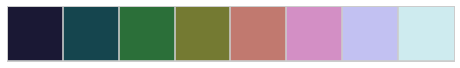

In [85]:
# Imports
%matplotlib inline
import pandas as pd
import chardet
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression

# Setup pandas
pd.options.display.max_rows = 400
pd.options.display.max_columns = None

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")
palette = sns.color_palette("cubehelix", 8)
sns.set_palette(palette)
sns.palplot(palette)

## Adding target column "Adopted" to User Level Data

In [101]:
# Read the egangement csv into a df call 'eng'
eng = pd.read_csv('takehome_user_engagement.csv')

# Get aquainted with eng
display(eng.head())
display(eng.info())

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
time_stamp    207917 non-null object
user_id       207917 non-null int64
visited       207917 non-null int64
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


None

In [102]:
# Because we need to know if users logged in on 3 seperate DATES within a 7 day period, group the df by user and date

# Transform time_stamp from object data type to datetime
eng['time_stamp'] = pd.to_datetime(eng['time_stamp']).dt.date

# Group by date and user_id
eng = pd.DataFrame(eng.groupby(['time_stamp','user_id'])['visited'].max().reset_index())

eng['time_stamp'] = pd.to_datetime(eng['time_stamp'])

eng.head()

,time_stamp,user_id,visited
0,2012-05-31,1693,1
1,2012-05-31,3428,1
2,2012-05-31,9899,1
3,2012-05-31,10012,1
4,2012-06-01,1995,1


In [104]:
# Need to find out which users within the engagement dataset "adopted" the service.
# The company defines adoption as having logged in on 3+ days within a 7 day period.

# Initialize a list
in_seven = []

# For each row in eng, append the number of engagements the user had within 7 days of that engagement
for ind in eng.index:
    start = eng.at[ind,'time_stamp']
    end = start + np.timedelta64(7, 'D')
    e = eng[(eng['time_stamp']>= start)&(eng['time_stamp']< end)&(eng['user_id']==eng.at[ind,'user_id'])]
    e = e.visited.count()
    in_seven.append(e)

# Add a column to eng that has number of times this user engaged within 7 days of the engagement of question
eng['in_seven'] = in_seven

# Create a new df that has the highest value of 'in_seven' for each user
adopts = pd.DataFrame(eng.groupby('user_id')['in_seven'].max())

# Filter that df to only include users that had 3 or more engagements in one week
adopts = adopts[adopts['in_seven']>=3]

# Add a column that indicates that this user did adopt the service
adopts['adopted'] = 1


In [105]:
# Open 'takehome_users.csv' and detect encoding using chardet
with open('takehome_users.csv', 'rb') as f:
    result = chardet.detect(f.read()) 

# Read 'takehome_users.csv' to a csv
df = pd.read_csv('takehome_users.csv', encoding=result['encoding'])

# Get aquainted with df
display(df.head())
display(df.describe())
display(df.info())

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


,object_id,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
count,12000.00000,8.823000e+03,12000.000000,12000.000000,12000.000000,6417.000000
mean,6000.50000,1.379279e+09,0.249500,0.149333,141.884583,5962.957145
std,3464.24595,1.953116e+07,0.432742,0.356432,124.056723,3383.761968
min,1.00000,1.338452e+09,0.000000,0.000000,0.000000,3.000000
25%,3000.75000,1.363195e+09,0.000000,0.000000,29.000000,3058.000000
50%,6000.50000,1.382888e+09,0.000000,0.000000,108.000000,5954.000000
75%,9000.25000,1.398443e+09,0.000000,0.000000,238.250000,8817.000000
max,12000.00000,1.402067e+09,1.000000,1.000000,416.000000,11999.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


None

In [106]:
# Merge user level data with adopts df
df = pd.merge(df, adopts, how='left', left_on='object_id', right_index=True)

# Assume that if the user was not included in adopts, then never adopted the service
df['adopted'] = df['adopted'].fillna(0)


## Feature Engineering and Data Exploration

In [107]:
# Transform creation_time from object type to datetime
df['creation_time'] = pd.to_datetime(df['creation_time'])

# Add column that shows number of days since the earliest creation time in the dataset (in case there was change in adoption rate over time)
df['days'] = (df['creation_time'] - np.min(df['creation_time'])).dt.days

In [108]:
# Function that extracts domain from email address
def domainsplit(x):
    try:
        return x.split('@')[1]
    except:
        return 'not a domain'

# Adding a column to df that is the domain
df['domain'] = df['email'].apply(lambda x: domainsplit(x))

# Looking for top domains
display(df.groupby('domain')['object_id'].count().sort_values(ascending=False))

# Replacing domain with 'other' 2 or fewer users with that domain
df['domain'] = np.where(df.domain.isin(['gmail.com','yahoo.com','jourrapide.com','cuvox.de','gustr.com','hotmail.com']),df.domain,'other')


domain
gmail.com         3562
yahoo.com         2447
jourrapide.com    1259
cuvox.de          1202
gustr.com         1179
hotmail.com       1165
qgjbc.com            2
xybhi.com            2
oqpze.com            2
luque.com            2
rerwl.com            2
dqwln.com            2
mumdc.com            2
xvnbr.com            2
jipcm.com            1
iiqgf.com            1
iovoe.com            1
inrxl.com            1
inrts.com            1
inpmp.com            1
innbs.com            1
imknl.com            1
ilhbl.com            1
jmifc.com            1
ilfsy.com            1
ilemx.com            1
ikcdl.com            1
jmlqy.com            1
ijvcz.com            1
iitsl.com            1
ihnru.com            1
ipcnh.com            1
igiwm.com            1
iggnw.com            1
igfhw.com            1
ifxcq.com            1
ifeeg.com            1
jnkly.com            1
ifdym.com            1
ieupn.com            1
ieunf.com            1
jnmxe.com            1
idrbg.com            1
jnoh

In [109]:
# Binners are variables that have a higher number of unique values
binners = ['days']

# Cats are categorical variables
cats = ['creation_source','domain']

# Function that generates a df of a feature versus the target variable, "adopted"
def df_feat(feature):
    dfa = df
    
    # If the feature is a binner
    # Create bins the size that splits the range from the smallest to the 95th percentil into 10 bins
    # Create a colum "feat" that is each value rounded to the nearest bin
    # Else, just use the feature value for the feat column
    if feature in binners:
        bucket_size  = (df[feature].quantile(.95) - np.min(df[feature]))/10
        dfa['feat'] = (dfa[feature]/bucket_size).apply(np.floor)
        dfa['feat'] = dfa['feat']*bucket_size
    else:
        dfa['feat'] = dfa[feature]
    
    # Create a df grouping by feature, with a column for the mean target and the number of observation at each value of feat
    dfa  = dfa.groupby('feat')['adopted'].agg(['mean','count']).reset_index()
    dfa['perc'] = dfa['count']*100.0/sum(dfa['count'])
    dfa['mean'] = dfa['mean']*100.0
    
    # If the resulting df is longer than 10 rows, only show the rows that cover the first 95% of the observations
    if len(dfa) > 10:
        dfa = dfa[dfa['perc'].cumsum()<=95]
    else:
        dfa = dfa
    
    # If the feature is a categorical variable, sort by highest mean target value (for easier plotting)
    if feature in cats:
        dfa = dfa.sort_values(by='mean', ascending=False)
    else:
        dfa = dfa
    
    # Return the df
    return dfa

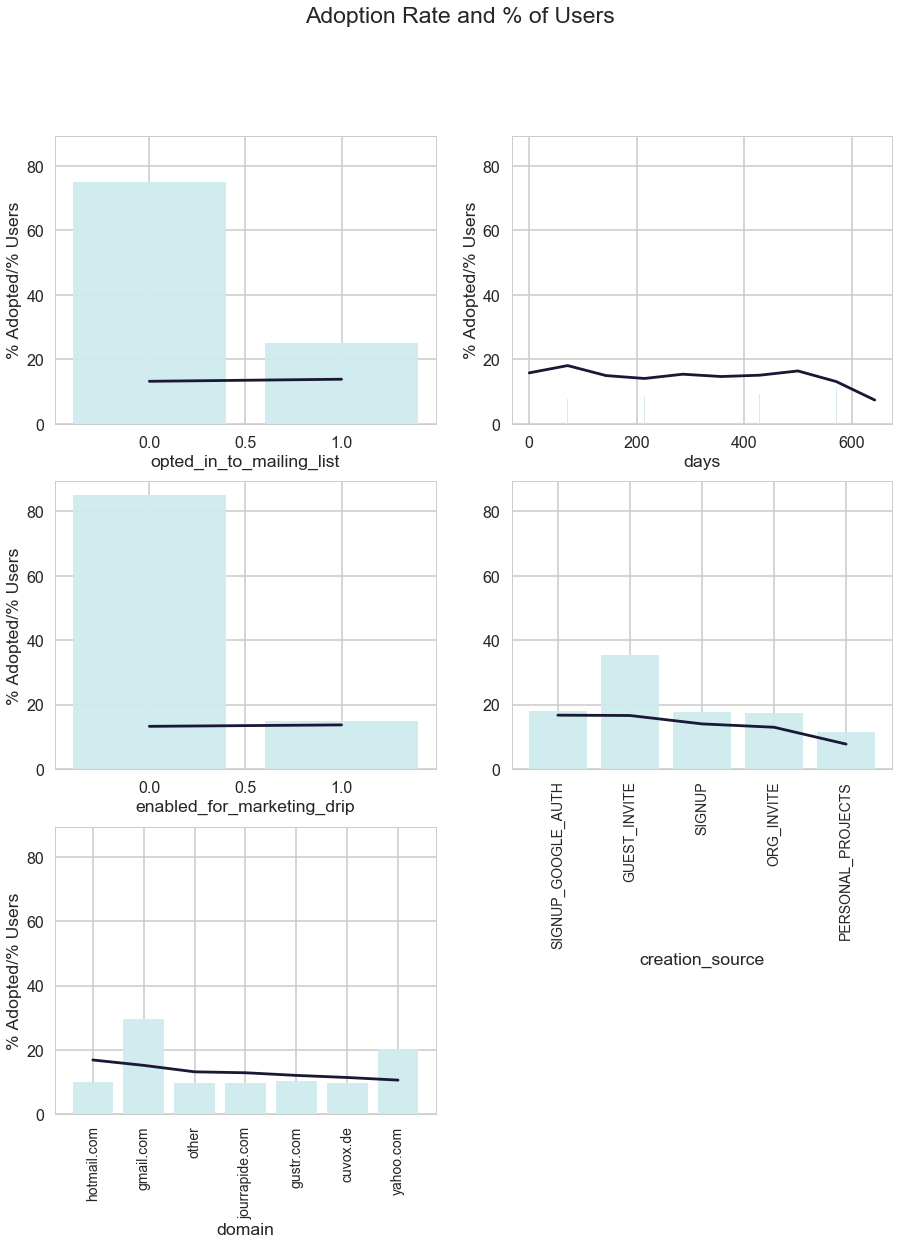

In [110]:
fig = plt.figure(figsize=(15,18))
plt.tight_layout()
fig.suptitle("Adoption Rate and % of Users")
#plt.subplots_adjust(hspace = 0.4)

ax1 = plt.subplot(3,2,1)
dfp = df_feat('opted_in_to_mailing_list')
plt.plot(dfp['feat'], dfp['mean'], color= palette[0])
plt.bar(dfp['feat'], dfp['perc'], color= palette[7], alpha = .95)
plt.ylabel('% Adopted/% Users')
plt.xlabel('opted_in_to_mailing_list')

plt.subplot(3,2,2, sharey=ax1)
dfp = df_feat('days')
plt.plot(dfp['feat'], dfp['mean'], color= palette[0])
plt.bar(dfp['feat'], dfp['perc'], color= palette[7], alpha = .95)
plt.ylabel('% Adopted/% Users')
plt.xlabel('days')

plt.subplot(3,2,3, sharey=ax1)
dfp = df_feat('enabled_for_marketing_drip')
plt.plot(dfp['feat'], dfp['mean'], color= palette[0])
plt.bar(dfp['feat'], dfp['perc'], color= palette[7], alpha = .95)
plt.xlabel('enabled_for_marketing_drip')
plt.ylabel('% Adopted/% Users')

plt.subplot(3,2, 4, sharey=ax1)
dfp = df_feat('creation_source')
plt.plot(range(len(dfp)), dfp['mean'], color= palette[0])
plt.bar(dfp['feat'], dfp['perc'], color= palette[7], alpha = .95)
plt.xticks(range(len(dfp)), dfp['feat'], fontsize=14)
plt.xlabel('creation_source')
plt.xticks(rotation=90)

plt.subplot(3,2, 5, sharey=ax1)
dfp = df_feat('domain')
plt.plot(range(len(dfp)), dfp['mean'], color= palette[0])
plt.bar(dfp['feat'], dfp['perc'], color= palette[7], alpha = .95)
plt.xticks(range(len(dfp)), dfp['feat'], fontsize=14)
plt.xlabel('domain')
plt.xticks(rotation=90)
plt.ylabel('% Adopted/% Users')

plt.show()

In [111]:
# Create dummy variables for cats
df = pd.get_dummies(df, columns=cats)

## Discovering Most Important Features with Logistic Regression

In [112]:
# Function that evaluates a model
def evaluate(model, X_test, y_test):
    predictions = model.predict(X_test)
    auc_roc = roc_auc_score(y_test, predictions)
    accuracy = sum(np.where(predictions==y_test,1,0))/len(y_test)
    precision = sum(np.where((predictions==y_test) & (predictions== 1),1,0))/sum(predictions)
    recall = sum(np.where((predictions==y_test) & (predictions== 1),1,0))/sum(y_test)
    f1 = (2 * precision * recall)/(precision + recall)
    pos_preds = np.mean(predictions)
    pos_actuals = np.mean(y_test)
    false_negatives = sum(np.where((predictions == 0) & (y_test == 1),1,0))/len(y_test)
    false_positives = sum(np.where((predictions == 1) & (y_test == 0),1,0))/len(y_test)
    
    print('')
    print('Model Performance')
    print('AUC ROC: {:0.1f}'.format(round(auc_roc*100,1)))
    print('F1: {:0.1f}'.format(round(f1*100,1)))
    print('Accuracy: {:0.1f}'.format(round(accuracy*100,1)),'%')
    print('Recall: {:0.1f}'.format(round(recall*100,1)),'%')
    print('Precision: {:0.1f}'.format(round(precision*100,1)),'%')
    print('Positive Predictions: {:0.1f}'.format(round(pos_preds*100,1)),'%')
    print('Positive Actuals: {:0.1f}'.format(round(pos_actuals*100,1)),'%')
    print('False Negatives: {:0.1f}'.format(round(false_negatives*100,1)),'%') 
    print('False Positives: {:0.1f}'.format(round(false_positives*100,1)),'%')

In [116]:
# Define features to use to predict target
xs = ['opted_in_to_mailing_list','enabled_for_marketing_drip','days',
      'creation_source_GUEST_INVITE','creation_source_ORG_INVITE', 
      'creation_source_PERSONAL_PROJECTS','creation_source_SIGNUP', 
      'creation_source_SIGNUP_GOOGLE_AUTH','domain_cuvox.de', 
      'domain_gmail.com', 'domain_gustr.com','domain_hotmail.com',
      'domain_jourrapide.com', 'domain_other', 'domain_yahoo.com'
     ]

# Create arrays for the features and the target: X, y
X, y = df.loc[:,xs], df.loc[:,'adopted']

# Create the training and test sets
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=.2, random_state=123)

In [117]:
# Normalize columns that are not_dummies
not_dummies = ['days']

#Find mean and standard deviation of all non-dummy columns
means = np.mean(X_train.loc[:,not_dummies], axis=0)
stds = np.std(X_train.loc[:,not_dummies], axis=0)

#Normalize non-dummy columns and make smaller dfs with normalized non-dummy features
normalized_train = (X_train.loc[:,not_dummies] - means)/stds
normalized_test = (X_test.loc[:,not_dummies] - means)/stds

#Drop non-normalized non-dummy columns
X_train = X_train.drop(not_dummies, axis=1)
X_test = X_test.drop(not_dummies, axis=1)

#Add normalized columns
X_train[not_dummies] = normalized_train
X_test[not_dummies] = normalized_test

# Check to make sure everything looks in order
display(X.describe())
display(y.describe())

,opted_in_to_mailing_list,enabled_for_marketing_drip,days,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH,domain_cuvox.de,domain_gmail.com,domain_gustr.com,domain_hotmail.com,domain_jourrapide.com,domain_other,domain_yahoo.com
count,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000
mean,0.249500,0.149333,411.029083,0.180250,0.354500,0.175917,0.173917,0.115417,0.100167,0.296833,0.098250,0.097083,0.104917,0.098833,0.203917
std,0.432742,0.356432,216.641508,0.384412,0.478381,0.380765,0.379054,0.319537,0.300235,0.456881,0.297665,0.296084,0.306459,0.298451,0.402925
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,229.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,431.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,607.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,729.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


count    12000.000000
mean         0.133500
std          0.340128
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: adopted, dtype: float64

In [118]:
# Using GridSearchCV to perform cross validation and grid search to find the best model over the training set
# Note: For C, smaller values mean stronger regularization. L1 is Lasso and L2 is ridge regression.
lr = LogisticRegression(class_weight = 'balanced', solver='lbfgs')
#parameters = {"C": [0.0001, 0.001, 0.1, 1, 10, 100, 1000], "penalty":['l1']}
parameters = {"C": [0.0001, 0.001, 0.1, 1, 10, 100, 1000]}
fitmodel = GridSearchCV(lr, param_grid=parameters, cv=5, scoring='accuracy', return_train_score=True)
fitmodel.fit(X_train, y_train)

# Helpful potential outputs are: fitmodel.best_estimator_, fitmodel.best_params_, fitmodel.best_score_
print('Evaluating Grid Search Model')
print("Best Params:",fitmodel.best_params_,"Best Score:", round(fitmodel.best_score_*100,1))
best_grid = fitmodel.best_estimator_
evaluate(best_grid,X_test, y_test)

Evaluating Grid Search Model
Best Params: {'C': 0.001} Best Score: 57.8

Model Performance
AUC ROC: 56.4
F1: 27.3
Accuracy: 57.7 %
Recall: 54.6 %
Precision: 18.2 %
Positive Predictions: 43.6 %
Positive Actuals: 14.6 %
False Negatives: 6.6 %
False Positives: 35.7 %


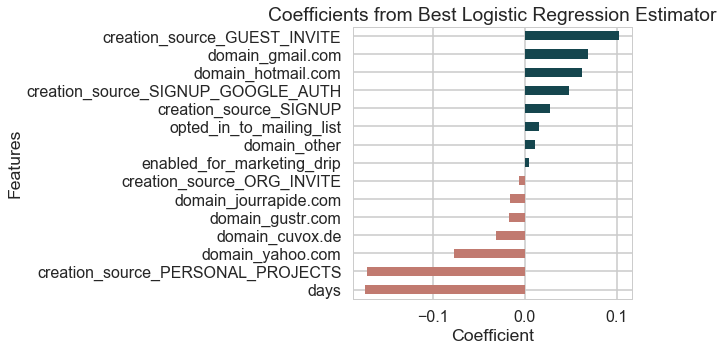

In [119]:
# Create df of Coefficients of Best Logistic Regression Estimator
coeff = list(best_grid.coef_[0])
labels = list(X_train.columns)
features = pd.DataFrame()
features['Features'] = labels
features['Coefficients'] = coeff
features.sort_values(by=['Coefficients'], ascending=True, inplace=True)
features['positive'] = features['Coefficients'] > 0
features.set_index('Features', inplace=True)

#Plot Horizontal Bar Graph of Coefficients
features['Coefficients'].plot(kind='barh', figsize=(5, 5),color = features.positive.map({True: palette[1], False: palette[4]}))
plt.title('Coefficients from Best Logistic Regression Estimator')
plt.xlabel('Coefficient')

plt.show()

## Conclusions and Suggestions for Further Study

In short, this model's performance was unimpressive, barely better than chance. However, it is interesting to see which features' coefficients have the largest magnitudes. It looks like, all else equal, those with a guest invitation are much more likely to adopt that those starting with a personal project. Users with standard domains like gmail and hotmail are more likely to adopt that less common domains. Those with yahoo domains are least likely to adopt. (Maybe likelyhood to adopts is positively correlated with tech savvy-ness? Maybe the company should target typically tech savvy demographics and should encourage guest invites. Unfortunately, it looks like drip campaigns and mailing lists have relatively little influence on adoption. Maybe Relax should work on making content for those more relevant or find a more effective mechanism to encourage adoption.


While there is certainly room for further optimization of this model, or room for choosing a different type fo model to address this question, another valuable pursuit could be adding new features to the dataset. You could 
1. add more data that is available to the dataset (maybe Relax Inc collects age or the reason why the user joined, but is not including it in the dataset)
2. collecting more data and add it to the dataset
3. or engineer more features (maybe there are interesting interactions between features like creation source and domain, or opting into mailing lists and being in a drip campaign)
